In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from scipy.optimize import brentq
import datetime

In [2]:
# 1d brownian motion (weiner process)
def brownian_motion(T, N):
    dt = T/N
    W = np.zeros(N)
    
    for i in range(1, N):
        W[i] = W[i-1] + np.random.normal()*np.sqrt(dt)
    
    return W

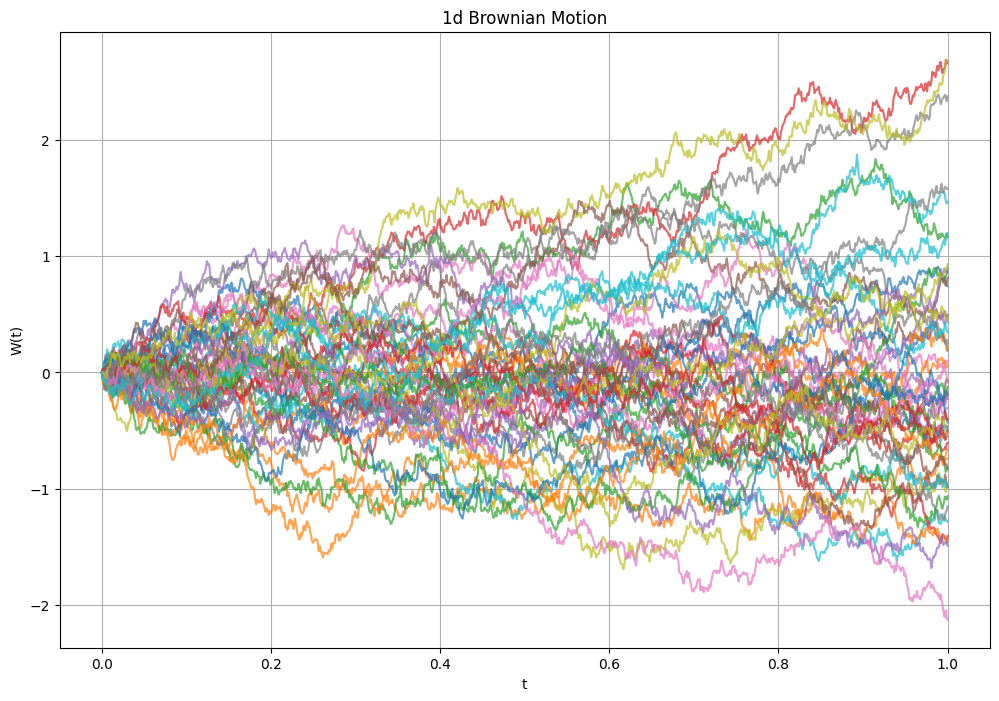

In [3]:
# simulate 100 brownian motions
t = np.linspace(0, 1, 1000)
plt.figure(figsize=(12, 8))
for i in range(50):
    plt.plot(t, brownian_motion(1, 1000), alpha=0.7)
    
plt.xlabel('t')
plt.ylabel('W(t)')
plt.title('1d Brownian Motion')
plt.grid()
plt.show()

In [4]:
def gbm(s_0, mu, sigma, T, N):
    s = np.zeros(N)
    W = brownian_motion(T, N)
    
    for i in range(N):
        s[i] = s_0*np.exp((mu - sigma**2/2)*i/N + sigma*W[i])
    
    return s

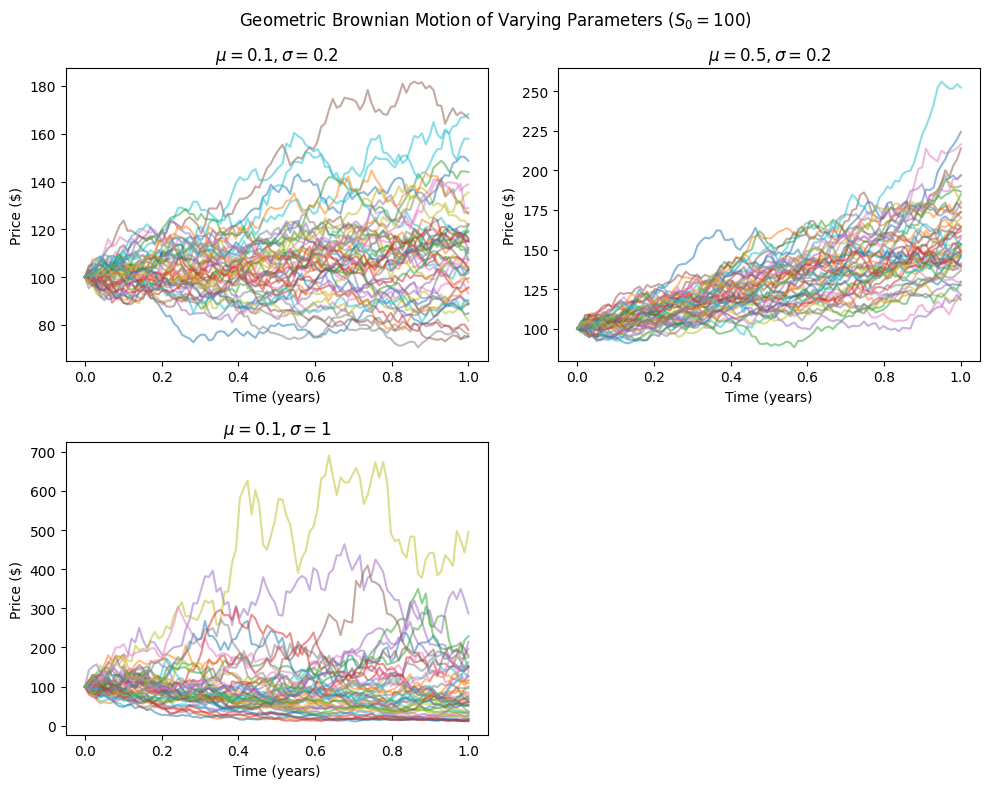

In [5]:
# simulate 100 geometric brownian motions
n = 100 # number of time steps
t = np.linspace(0, 1, n)
s_0 = 100 # initial stock price
mu1 = 0.1 # expected return (drift)
mu2 = 0.5
sigma1 = 0.2 # volatility (diffusion)
sigma2 = 1

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for i in range(50):
    ax[0,0].plot(t, gbm(s_0, mu1, sigma1, 1, n), alpha=0.5)
    ax[0,1].plot(t, gbm(s_0, mu2, sigma1, 1, n), alpha=0.5)
    ax[1,0].plot(t, gbm(s_0, mu1, sigma2, 1, n), alpha=0.5)

ax[0, 0].set_xlabel('Time (years)')
ax[0, 0].set_ylabel('Price ($)')
ax[0, 0].set_title(rf'$\mu = {mu1}, \sigma = {sigma1}$')

ax[0, 1].set_xlabel('Time (years)')
ax[0, 1].set_ylabel('Price ($)')
ax[0, 1].set_title(rf'$\mu = {mu2}, \sigma = {sigma1}$')

ax[1, 0].set_xlabel('Time (years)')
ax[1, 0].set_ylabel('Price ($)')
ax[1, 0].set_title(rf'$\mu = {mu1}, \sigma = {sigma2}$')

fig.delaxes(ax[1, 1])
fig.suptitle(
    rf'Geometric Brownian Motion of Varying Parameters ($S_0 = {s_0}$)'
)
plt.tight_layout()
plt.show()

In [6]:
# black-scholes
def black_scholes_call(s_0, k, t, r, sigma):
    d_1 = (np.log(s_0/k) + (r + sigma**2/2)*t)/(sigma*np.sqrt(t))
    d_2 = d_1 - sigma*np.sqrt(t)
    c = norm.cdf(d_1)*s_0 - norm.cdf(d_2)*k*np.exp(-r*t)

    return c

In [7]:
# sensitivity analysis
# base parameters
s0 = 100
t = 0.25 # expires in 1 quarter
r = 0.04
sigma = 0.2
k = 95

# vary stock price s_0
d_s0 = np.linspace(s0*0.5, s0*1.5, 100)
c_s0 = [black_scholes_call(x, k, t, r, sigma) for x in d_s0]

# vary strike price k
d_k = np.linspace(k*0.5, k*1.5, 100)
c_k = [black_scholes_call(s0, x, t, r, sigma) for x in d_k]

# vary time to expiration t
d_t = np.linspace(0.001, 1, 100)
c_t = [black_scholes_call(s0, k, x, r, sigma) for x in d_t]

# vary risk-free rate r
d_r = np.linspace(0.001, 0.1, 100)
c_r = [black_scholes_call(s0, k, t, x, sigma) for x in d_r]

# vary volatility sigma
d_sigma = np.linspace(0.001, 0.5, 100)
c_sigma = [black_scholes_call(s0, k, t, r, x) for x in d_sigma]

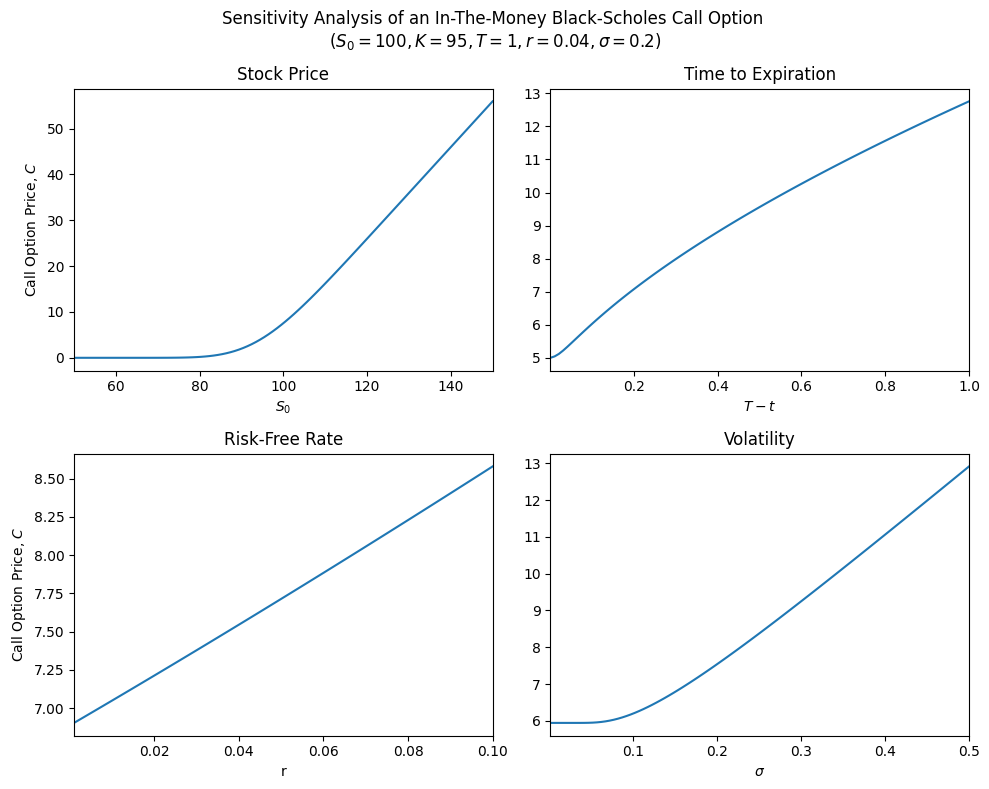

In [8]:
# plot
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].set_ylabel(rf'Call Option Price, $C$')
ax[0, 0].plot(d_s0, c_s0)
ax[0, 0].set_title('Stock Price')
ax[0, 0].set_xlabel(rf'$S_0$')
ax[0, 0].set_xlim([np.min(d_s0), np.max(d_s0)])

ax[0, 1].plot(d_t, c_t)
ax[0, 1].set_title('Time to Expiration')
ax[0, 1].set_xlabel(rf'$T-t$')
ax[0, 1].set_xlim([np.min(d_t), np.max(d_t)])

ax[1, 0].set_ylabel(rf'Call Option Price, $C$')
ax[1, 0].plot(d_r, c_r)
ax[1, 0].set_title('Risk-Free Rate')
ax[1, 0].set_xlabel(rf'r')
ax[1, 0].set_xlim([np.min(d_r), np.max(d_r)])

ax[1, 1].plot(d_sigma, c_sigma)
ax[1, 1].set_title('Volatility')
ax[1, 1].set_xlabel(rf'$\sigma$')
ax[1, 1].set_xlim([np.min(d_sigma), np.max(d_sigma)])

fig.suptitle(
    'Sensitivity Analysis of an In-The-Money Black-Scholes Call Option \n'
    rf'($S_0 = {s_0}, K = {k}, T = {1}, r = {r}, \sigma = {sigma}$)'
)
plt.tight_layout()
plt.show()

In [9]:
# options data
TICKER = 'NVDA'
ticker = yf.Ticker(TICKER)
expire_date = ticker.options[6]
option_data = ticker.option_chain(expire_date).calls
option_data['expireDate'] = expire_date
option_data = option_data[option_data['strike'] == 130]

# historical price data
date = datetime.datetime.today()
end_date = date.strftime('%Y-%m-%d')
start_date = (date - datetime.timedelta(days=365)).strftime('%Y-%m-%d')
price_data = yf.download(TICKER, start=start_date, end=end_date)['Adj Close']

# risk free rate
rf = yf.Ticker('^TNX').info['previousClose']/100

[*********************100%%**********************]  1 of 1 completed


In [10]:
option_data

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expireDate
168,NVDA241220C00130000,2024-10-23 19:59:02+00:00,130.0,18.18,18.05,18.35,-2.770001,-13.221959,2091.0,120693.0,0.601566,True,REGULAR,USD,2024-12-20


In [11]:
# calculating options price using black-scholes
strike_price = option_data['strike'].values[0]
days_till_exp = len(pd.bdate_range(
    start=date,
    end=option_data['expireDate'].values[0]
))
calculated_sigma = price_data.pct_change().dropna().std()*np.sqrt(252)
# stock_price = price_data.iloc[-1]
stock_price = 139.56 # yfinance data is not updated for some reason, manually inputting the current price

calculated_price = black_scholes_call(
    stock_price,
    strike_price,
    days_till_exp/252,
    rf,
    calculated_sigma
)

In [12]:
print(f'Calculated price of CALL Option based on Black-Scholes: ${calculated_price.round(2)}')
print(f'Actual price of CALL Option: ${option_data["lastPrice"].values[0]}')

Calculated price of CALL Option based on Black-Scholes: $17.47
Actual price of CALL Option: $18.18


In [13]:
# implied volatility
def implied_volatility(s0, k, t, r, actual_price):
    # optimize objective function to equal 0
    objective_function = lambda x: black_scholes_call(s0, k, t, r, x) - actual_price

    # root finding
    return brentq(objective_function, 0.0001, 1)

In [14]:
actual_price = option_data['lastPrice'].values[0]
implied_vol = implied_volatility(
    stock_price,
    strike_price,
    days_till_exp/252,
    rf,
    actual_price
)
actual_implied_vol = option_data['impliedVolatility'].values[0]

print(f'Calculated Volatility: {calculated_sigma}')
print(f'Calculated Implied Volatility: {implied_vol}')
print(f'Given Implied Volatility: {actual_implied_vol}')

Calculated Volatility: 0.5193920354395534
Calculated Implied Volatility: 0.553844926857719
Given Implied Volatility: 0.6015664843750002


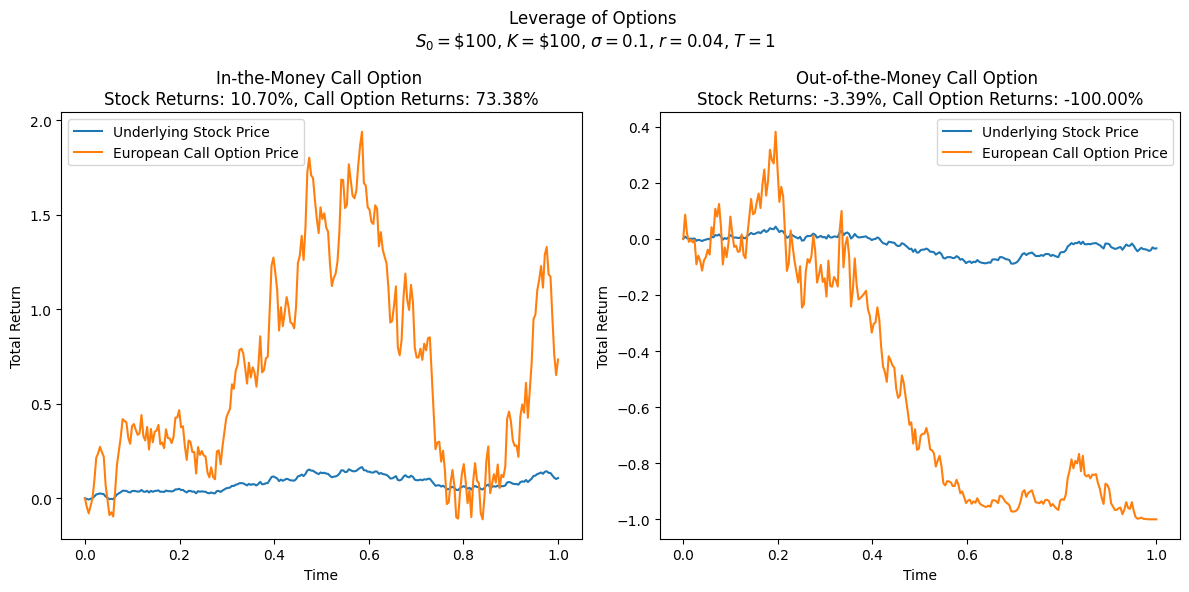

In [15]:
# visualize leverage
n = 252 # number of time steps
t = np.linspace(0, 1, n)
s_0 = 100 # initial stock price
mu_1 = 0.05 # expected return (drift)
sigma = 0.1 # volatility (diffusion)
rf = 0.04
k = 100
mu_2 = -0.05
np.random.seed(456)

stock_prices_1 = gbm(s_0, mu_1, sigma, 1, n)
stock_prices_2 = gbm(s_0, mu_2, sigma, 1, n)
stock_returns_1 = (stock_prices_1 - stock_prices_1[0]) / stock_prices_1[0]
stock_returns_2 = (stock_prices_2 - stock_prices_2[0]) / stock_prices_2[0]

itm_call = [black_scholes_call(x, k, 1-i*1/n, rf, sigma) for i, x in enumerate(stock_prices_1)]
otm_call = [black_scholes_call(x, k, 1-i*1/n, rf, sigma) for i, x in enumerate(stock_prices_2)]
itm_returns = (itm_call - itm_call[0]) / itm_call[0]
otm_returns = (otm_call - otm_call[0]) / otm_call[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(t, stock_returns_1, label='Underlying Stock Price')
ax[0].plot(t, itm_returns, label='European Call Option Price')
ax[0].set_title(
    'In-the-Money Call Option \n'
    f'Stock Returns: {100*stock_returns_1[-1]:.2f}%, Call Option Returns: {100*itm_returns[-1]:.2f}%'
)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Total Return')
ax[0].legend()

ax[1].plot(t, stock_returns_2, label='Underlying Stock Price')
ax[1].plot(t, otm_returns, label='European Call Option Price')
ax[1].set_title(
    'Out-of-the-Money Call Option \n'
    f'Stock Returns: {100*stock_returns_2[-1]:.2f}%, Call Option Returns: {100*otm_returns[-1]:.2f}%'
)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Total Return')
ax[1].legend()

fig.suptitle(
    'Leverage of Options \n'
    rf'$S_0 = \${s_0}$, $K = \${k}$, $\sigma = {sigma}$, $r = {rf}$, $T = 1$'
)

plt.tight_layout()
plt.show()

In [16]:
# delta
def calc_delta(s0, k, t, r, sigma):
    d_1 = (np.log(s0/k) + (r + sigma**2/2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d_1)

In [17]:
def delta_hedge(prices, sigma, rf, k, n):
    call_prices = np.array([black_scholes_call(x, k, 1-i*1/n, rf, sigma) for i, x in enumerate(prices)]).round(2)
    delta = np.array([calc_delta(x, k, 1-i*1/n, rf, sigma) for i, x in enumerate(prices)]).round(2)
    
    # Create hedge positions
    total_shares = np.array([delta[i] for i in range(n)])*100  # long delta shares
    change = np.array([total_shares[i] - total_shares[i-1] if i > 0 else total_shares[i] for i in range(n)]).round(2)
    cashflow = np.array([-change[i]*prices[i] for i in range(n)]).round(2)

    # close all positions at the end
    last_position = total_shares[-1]
    change = np.append(change, -last_position)
    cashflow = np.append(cashflow, -change[-1]*prices[-1])
    total_shares = np.append(total_shares, 0)
    prices = np.append(prices, None)
    call_prices = np.append(call_prices, None)
    delta = np.append(delta, None)
    
    # interest on cashflows
    interest = np.array([cashflow[i]*rf/252*(n-i) for i in range(n)]).round(2)
    interest[0] = 0  # no interest on initial cashflow
    interest = np.append(interest, 0)
    
    df = pd.DataFrame(
        {
        'stock price': prices,
        'call price': call_prices,
        'delta': delta,
        'adjustment': [f'sell {abs(x)}' if x < 0 else f'buy {abs(x)}' for x in change],
        'shares held': total_shares,
        'cashflow': cashflow,
        'carry (interest)': interest
        },
    )
    
    # profit loss
    net_cashflow = np.sum(cashflow)
    call_premium = call_prices[0]*100  # Premium received for short calls
    exercise_value = -max(prices[-2] - k, 0)*100  # Cost of exercise
    call_carry = call_premium*rf  # Cost of carrying short calls
    stock_carry = np.sum(interest)  # Interest on cash
    
    
    total_profit = net_cashflow + call_premium + exercise_value + call_carry + stock_carry
    initial_investment = np.abs(cashflow[0] + call_premium)
    total_returns = total_profit / initial_investment
    
    return df, total_profit, total_returns

In [18]:
df, profit, returns = delta_hedge(stock_prices_1.round(2), sigma, rf, k, n)

print(f'Total Profit: ${profit:.2f}')
print(f'Total Returns: {100*returns:.2f}%')

Total Profit: $277.90
Total Returns: 4.57%


In [19]:
df

,stock price,call price,delta,adjustment,shares held,cashflow,carry (interest)
0,100.0,6.18,0.67,buy 67.0,67.0,-6700.00,0.00
1,99.6,5.9,0.66,sell 1.0,66.0,99.60,3.97
2,99.3,5.68,0.65,sell 1.0,65.0,99.30,3.94
3,99.71,5.93,0.66,buy 1.0,66.0,-99.71,-3.94
4,100.08,6.16,0.68,buy 2.0,68.0,-200.16,-7.88
...,...,...,...,...,...,...,...
248,112.03,12.09,1.0,buy 0.0,100.0,-0.00,-0.00
249,110.81,10.86,1.0,buy 0.0,100.0,-0.00,-0.00
250,110.17,10.2,1.0,buy 0.0,100.0,-0.00,-0.00
251,110.7,10.72,1.0,buy 0.0,100.0,-0.00,-0.00


In [22]:
# simulate 1000 returns of delta hedging vs buy-and-hold
hold_returns, hedge_returns = [], []

for _ in range(1000):
    price = gbm(s_0, 0.2, 0.5, 1, n).round(2)
    hold_returns.append((price[-1] - price[0]) / price[0])
    _, _, hedge = delta_hedge(price, sigma, rf, k, n)
    hedge_returns.append(hedge)

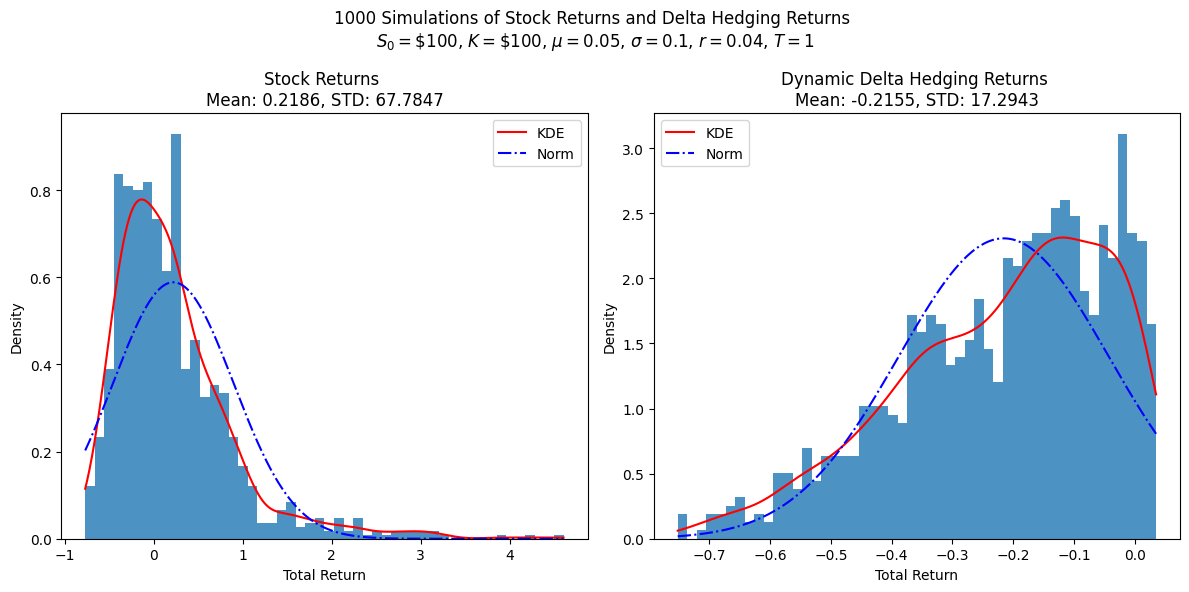

In [23]:
# KDE and normal distribution
hold_mean = np.mean(hold_returns)
hold_std = np.std(hold_returns)
hold_kde = gaussian_kde(hold_returns)
x_hold = np.linspace(min(hold_returns), max(hold_returns), 1000)
hold_kde_values = hold_kde(x_hold)
hold_norm = norm.pdf(x_hold, hold_mean, hold_std)

hedge_mean = np.mean(hedge_returns)
hedge_std = np.std(hedge_returns)
hedge_kde = gaussian_kde(hedge_returns)
x_hedge = np.linspace(min(hedge_returns), max(hedge_returns), 1000)
hedge_kde_values = hedge_kde(x_hedge)
hedge_norm = norm.pdf(x_hedge, hedge_mean, hedge_std)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(hold_returns, bins=50, density=True, alpha=0.8)
ax[0].plot(x_hold, hold_kde_values, color='red', label='KDE')
ax[0].plot(x_hold, hold_norm, color='blue', linestyle='-.', label='Norm')
ax[0].set_title(
    'Stock Returns \n'
    f'Mean: {hold_mean:.4f}, STD: {100*hold_std:.4f}'
)
ax[0].set_xlabel('Total Return')
ax[0].set_ylabel('Density')
ax[0].legend()

ax[1].hist(hedge_returns, bins=50, density=True, alpha=0.8)
ax[1].plot(x_hedge, hedge_kde_values, color='red', label='KDE')
ax[1].plot(x_hedge, hedge_norm, color='blue', linestyle='-.', label='Norm')
ax[1].set_title(
    'Dynamic Delta Hedging Returns \n'
    f'Mean: {hedge_mean:.4f}, STD: {100*hedge_std:.4f}'
)
ax[1].set_xlabel('Total Return')
ax[1].set_ylabel('Density')
ax[1].legend()

fig.suptitle(
    f'1000 Simulations of Stock Returns and Delta Hedging Returns \n'
    rf'$S_0 = \${s_0}$, $K = \${k}$, $\mu = {mu_1}$, $\sigma = {sigma}$, $r = {rf}$, $T = 1$'
)
fig.tight_layout()
plt.show()